# Deep Learning Models
## Goals
1. Implement a Feedforward Neural Network for superhost classification with pytorch.
2. Set up a training loop with validation, early stopping, and learning rate scheduling.
3. Evaluate the Neural Network using the established classification metrics.
4. Visualize training progress (loss curves) to diagnose overfitting or underfitting.

In [10]:
# Imports
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from numpy.typing import NDArray
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

In [11]:
# %% Constants
PROCESSED_DATA_DIR = Path("../../data/cleaned/classification/")
FIGURES_DIR = Path("../../figures/classification/")
MODELS_DIR = Path("../../models/classification/")

RANDOM_STATE: int = 42
torch.manual_seed(RANDOM_STATE)  # Set PyTorch seed for reproducibility

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [12]:
# Load data
print("Loading feature-engineered data...")
X_train = pl.read_parquet(PROCESSED_DATA_DIR / "X_train_scaled.parquet")
X_val = pl.read_parquet(PROCESSED_DATA_DIR / "X_val_scaled.parquet")
y_train = pl.read_parquet(PROCESSED_DATA_DIR / "y_train.parquet")
y_val = pl.read_parquet(PROCESSED_DATA_DIR / "y_val.parquet")

# Convert to numpy
X_train_np = X_train.to_numpy()
X_val_np = X_val.to_numpy()
y_train_np = y_train.to_numpy().ravel()
y_val_np = y_val.to_numpy().ravel()

print(f"X_train: {X_train_np.shape}, y_train: {y_train_np.shape}")
print(f"X_val: {X_val_np.shape}, y_val: {y_val_np.shape}")

# Class distribution
unique, counts = np.unique(y_train_np, return_counts=True)
print(f"\nClass distribution in training set:")
print(
    f"  Class 0 (Not Superhost): {counts[0]} ({counts[0] / len(y_train_np) * 100:.1f}%)"
)
print(f"  Class 1 (Superhost): {counts[1]} ({counts[1] / len(y_train_np) * 100:.1f}%)")

Loading feature-engineered data...
X_train: (9440, 127), y_train: (9440,)
X_val: (1977, 127), y_val: (1977,)

Class distribution in training set:
  Class 0 (Not Superhost): 5394 (57.1%)
  Class 1 (Superhost): 4046 (42.9%)


In [13]:
# Create DataLoader
BATCH_SIZE = 32

train_dataset = TensorDataset(
    torch.FloatTensor(X_train_np), torch.LongTensor(y_train_np)
)
val_dataset = TensorDataset(torch.FloatTensor(X_val_np), torch.LongTensor(y_val_np))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

DataLoaders created:
  Training batches: 295
  Validation batches: 62


In [14]:
# Define Evaluation Function
def evaluate_model(
    model_name: str,
    y_train_pred: NDArray[np.bool],
    y_val_pred: NDArray[np.bool],
    y_train_true: NDArray[np.bool_],
    y_train_pred_proba: NDArray[...] = None,
    y_val_pred_proba: NDArray[...] = None,
):
    results = {}
    train_metrics = {
        "Accuracy": accuracy_score(y_train_true, y_train_pred),
        "Precision": precision_score(y_train_true, y_train_pred, zero_division=0),
        "Recall": recall_score(y_train_true, y_train_pred, zero_division=0),
        "F1": f1_score(y_train_true, y_train_pred, zero_division=0),
        "Balanced Accuracy": balanced_accuracy_score(y_train_true, y_train_pred),
    }

    if y_train_pred_proba is not None:
        train_metrics["ROC-AUC"] = roc_auc_score(y_train_true, y_train_pred_proba)

    print(f"\033[1m{model_name}: Training Set\033[0m")
    for metric, value in train_metrics.items():
        print(f"  \033[1m{metric:20}:\033[0m {value:.4f}")
    print("")

    results["train"] = train_metrics

    val_metrics = {
        "Accuracy": accuracy_score(y_val_np, y_val_pred),
        "Precision": precision_score(y_val_np, y_val_pred, zero_division=0),
        "Recall": recall_score(y_val_np, y_val_pred, zero_division=0),
        "F1": f1_score(y_val_np, y_val_pred, zero_division=0),
        "Balanced Accuracy": balanced_accuracy_score(y_val_np, y_val_pred),
    }

    if y_val_pred_proba is not None:
        val_metrics["ROC-AUC"] = roc_auc_score(y_val_np, y_val_pred_proba)

    print(f"\033[1m{model_name}: Validation Set\033[0m")
    for metric, value in val_metrics.items():
        print(f"  \033[1m{metric:20}:\033[0m {value:.4f}")
    print("")

    # Confusion matrix
    cm = confusion_matrix(y_val_np, y_val_pred)
    print(f"\n\033[1mConfusion Matrix: Validation Set\033[0m")
    print(f"  \033[1mTN:\033[0m {cm[0, 0]:<6} \033[1mFP:\033[0m {cm[0, 1]:<6}")
    print(f"  \033[1mFN:\033[0m {cm[1, 0]:<6} \033[1mTP:\033[0m {cm[1, 1]:<6}")

    results["val"] = val_metrics
    results["confusion_matrix"] = cm

    return results

## Neural Network
Our Neural network will only allow forward propagation between neurons.

Our MLP will use a **pyramidal structure** (127 → 64 → 32 → 2):
- **Input layer (127 neurons)**: Accommodates {input_features} input features
- **Hidden layers**: Progressively compress information
- **Regularization**: BatchNorm + Dropout (0.4-0.5) prevent overfitting
- **Activation**: ReLU for non-linearity
- **Output**: Two neurons (binary classification target)

In [15]:
class ClassifierNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(ClassifierNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 127),
            nn.BatchNorm1d(127),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(127, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout_rate * 0.8),
            nn.ReLU(),
            nn.Linear(32, 2),  # Output layer for classification
        )

    def forward(self, x):
        return self.network(x)


input_features = X_train_np.shape[1]
nn_model = ClassifierNN(input_features).to(device)

print(f"Neural Network Architecture (Input Dim: {input_features}, Device: {device}):\n")
print(nn_model)

Neural Network Architecture (Input Dim: 127, Device: mps):

ClassifierNN(
  (network): Sequential(
    (0): Linear(in_features=127, out_features=127, bias=True)
    (1): BatchNorm1d(127, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=127, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [16]:
# Training Parameters
epochs = 200
learning_rate = 0.001
weight_decay = 1e-4

# Cost Function Parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    nn_model.parameters(), lr=learning_rate, weight_decay=weight_decay
)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10)

# Early Stopping Parameters
patience = 30
best_val_loss = float("inf")
patience_counter = 0
train_losses = []
val_losses = []


# Training function
def train_epoch(model, train_loader):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate(model, data_loader):
    """Evaluate per epoch."""
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Prob of class 1
            all_labels.extend(y_batch.cpu().numpy())

    return (
        total_loss / len(data_loader),
        np.array(all_preds),
        np.array(all_probs),
        np.array(all_labels),
    )

In [17]:
for epoch in range(epochs):
    train_loss = train_epoch(nn_model, train_loader)
    val_loss, val_preds, val_probs, val_labels = evaluate(nn_model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    unique, counts = np.unique(val_preds, return_counts=True)
    pred_dist = dict(zip(unique, counts))

    print(
        f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, "
        f"Validation Loss: {val_loss:.4f}, "
        f"Current LR: {optimizer.param_groups[0]['lr']:.6f}"
    )

    scheduler.step(val_loss)  # Step on val_loss

    # Early stopping (monitoring val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(nn_model.state_dict(), MODELS_DIR / "standard_nn_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

nn_model.load_state_dict(torch.load(MODELS_DIR / "standard_nn_best.pth"))
print(f"Best validation loss: {best_val_loss:.4f}")

Epoch 1/200, Train Loss: 0.4234, Validation Loss: 0.2895, Current LR: 0.001000
Epoch 2/200, Train Loss: 0.2838, Validation Loss: 0.2318, Current LR: 0.001000
Epoch 3/200, Train Loss: 0.2495, Validation Loss: 0.1954, Current LR: 0.001000
Epoch 4/200, Train Loss: 0.2444, Validation Loss: 0.2041, Current LR: 0.001000
Epoch 5/200, Train Loss: 0.2216, Validation Loss: 0.1916, Current LR: 0.001000
Epoch 6/200, Train Loss: 0.2115, Validation Loss: 0.1683, Current LR: 0.001000
Epoch 7/200, Train Loss: 0.2033, Validation Loss: 0.1787, Current LR: 0.001000
Epoch 8/200, Train Loss: 0.1973, Validation Loss: 0.1886, Current LR: 0.001000
Epoch 9/200, Train Loss: 0.1883, Validation Loss: 0.1760, Current LR: 0.001000
Epoch 10/200, Train Loss: 0.1834, Validation Loss: 0.1576, Current LR: 0.001000
Epoch 11/200, Train Loss: 0.1757, Validation Loss: 0.1604, Current LR: 0.001000
Epoch 12/200, Train Loss: 0.1788, Validation Loss: 0.1656, Current LR: 0.001000
Epoch 13/200, Train Loss: 0.1786, Validation Loss

In [ ]:
# Evaluate Model
nn_model.load_state_dict(torch.load(MODELS_DIR / "standard_nn_best.pth"))
train_final_loss, train_final_preds, train_final_probs, train_final_labels = evaluate(
    nn_model, train_loader
)
val_final_loss, val_final_preds, val_final_probs, _ = evaluate(nn_model, val_loader)

metrics = evaluate_model(
    "Neural Network",
    train_final_preds,
    val_final_preds,
    train_final_labels,
    train_final_probs,
    val_final_probs,
)

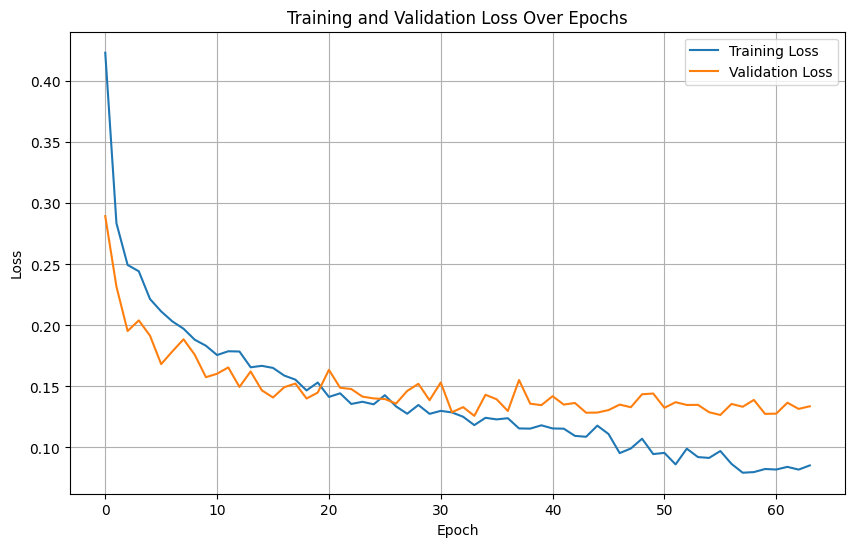

In [203]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig(FIGURES_DIR / "nn_loss_curve.png")
plt.show()

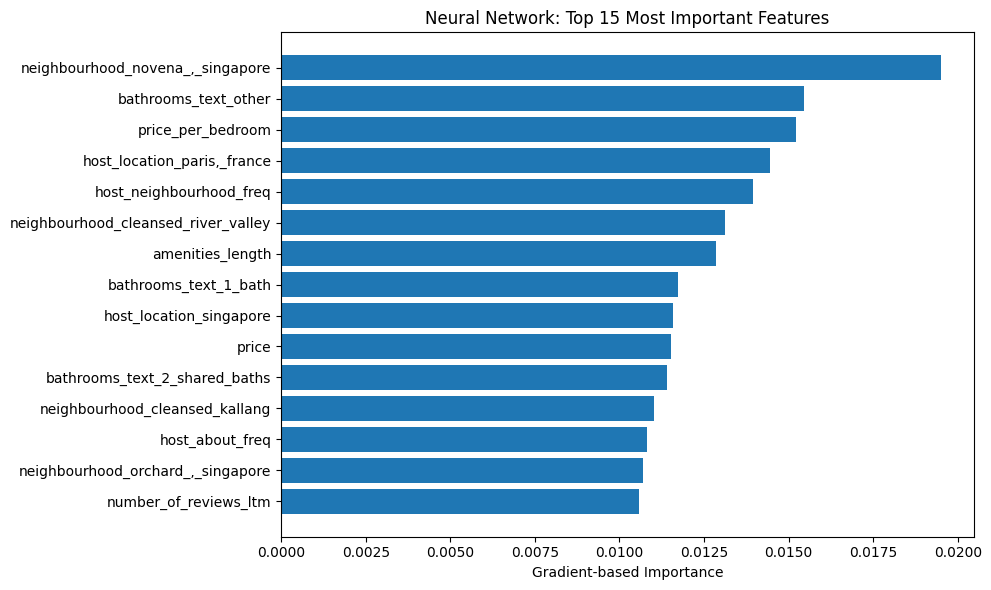

Top 10 Features (Neural Network):
 1. price                                    0.0115
 2. host_location_singapore                  0.0116
 3. bathrooms_text_1_bath                    0.0117
 4. amenities_length                         0.0128
 5. neighbourhood_cleansed_river_valley      0.0131
 6. host_neighbourhood_freq                  0.0139
 7. host_location_paris,_france              0.0144
 8. price_per_bedroom                        0.0152
 9. bathrooms_text_other                     0.0155
10. neighbourhood_novena_,_singapore         0.0195


In [218]:
def compute_feature_importance(model, data_loader, device):
    """Compute feature importance using input gradients."""
    model.eval()
    all_grads = []

    for X_batch, _ in data_loader:
        X_batch = X_batch.to(device)
        X_batch.requires_grad = True

        logits = model(X_batch)
        # Backprop from positive class (superhost) predictions
        loss = logits[:, 1].sum()
        loss.backward()

        all_grads.append(X_batch.grad.abs().detach().cpu().numpy())
        X_batch.requires_grad = False

    # Average gradient magnitude across all samples
    feature_importance = np.concatenate(all_grads).mean(axis=0)
    return feature_importance / feature_importance.sum()  # Normalize


# Get feature names (adjust based on your feature columns)
feature_names = X_train.columns

# Compute importance
nn_importance = compute_feature_importance(nn_model, val_loader, device)

# Plot top 15 features
top_n = 15
top_indices = np.argsort(nn_importance)[-top_n:]
top_features = [feature_names[i] for i in top_indices]
top_importance = nn_importance[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importance)
plt.yticks(range(top_n), top_features)
plt.xlabel("Gradient-based Importance")
plt.title("Neural Network: Top 15 Most Important Features")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "nn_feature_importance.png", dpi=300)
plt.show()

print("Top 10 Features (Neural Network):")
for i, (feat, imp) in enumerate(zip(top_features[-10:], top_importance[-10:]), 1):
    print(f"{i:2d}. {feat:40s} {imp:.4f}")

## Comparison 

In [225]:
# Load Random Forest model
with open(MODELS_DIR / "random_forest.pkl", "rb") as f:
    rf_model = pickle.load(f)

# Get RF predictions on validation set
rf_val_preds = rf_model.predict(X_val_np)
rf_val_probs = rf_model.predict_proba(X_val_np)[:, 1]

# Calculate RF metrics
rf_metrics = {
    "Accuracy": accuracy_score(y_val_np, rf_val_preds),
    "Precision": precision_score(y_val_np, rf_val_preds, zero_division=0),
    "Recall": recall_score(y_val_np, rf_val_preds, zero_division=0),
    "F1": f1_score(y_val_np, rf_val_preds, zero_division=0),
    "ROC-AUC": roc_auc_score(y_val_np, rf_val_probs),
    "Balanced Accuracy": balanced_accuracy_score(y_val_np, rf_val_preds),
}

# Create comparison dataframe
comparison_df = pd.DataFrame(
    {
        "Neural Network": metrics["val"],
        "Random Forest": rf_metrics,
    }
)

print("\033[1mValidation Set (Neural Network vs Random Forest)\033[0m")
display(comparison_df.round(4))

# Calculate differences
print("\033[1m\nPerformance Difference:\033[0m")
for metric in comparison_df.index:
    diff = (
        comparison_df.loc[metric, "Neural Network"]
        - comparison_df.loc[metric, "Random Forest"]
    )
    print(f"{metric:20s}: {diff:+.4f}")

Validation Set (Neural Network vs Random Forest)


,Neural Network,Random Forest
Accuracy,0.9540,0.9611
Precision,0.8306,0.8199
Recall,0.8008,0.8884
F1,0.8154,0.8528
Balanced Accuracy,0.8885,0.9300
ROC-AUC,0.9756,0.9858


Performance Difference:
Accuracy            : -0.0071
Precision           : +0.0107
Recall              : -0.0876
F1                  : -0.0374
Balanced Accuracy   : -0.0415
ROC-AUC             : -0.0102


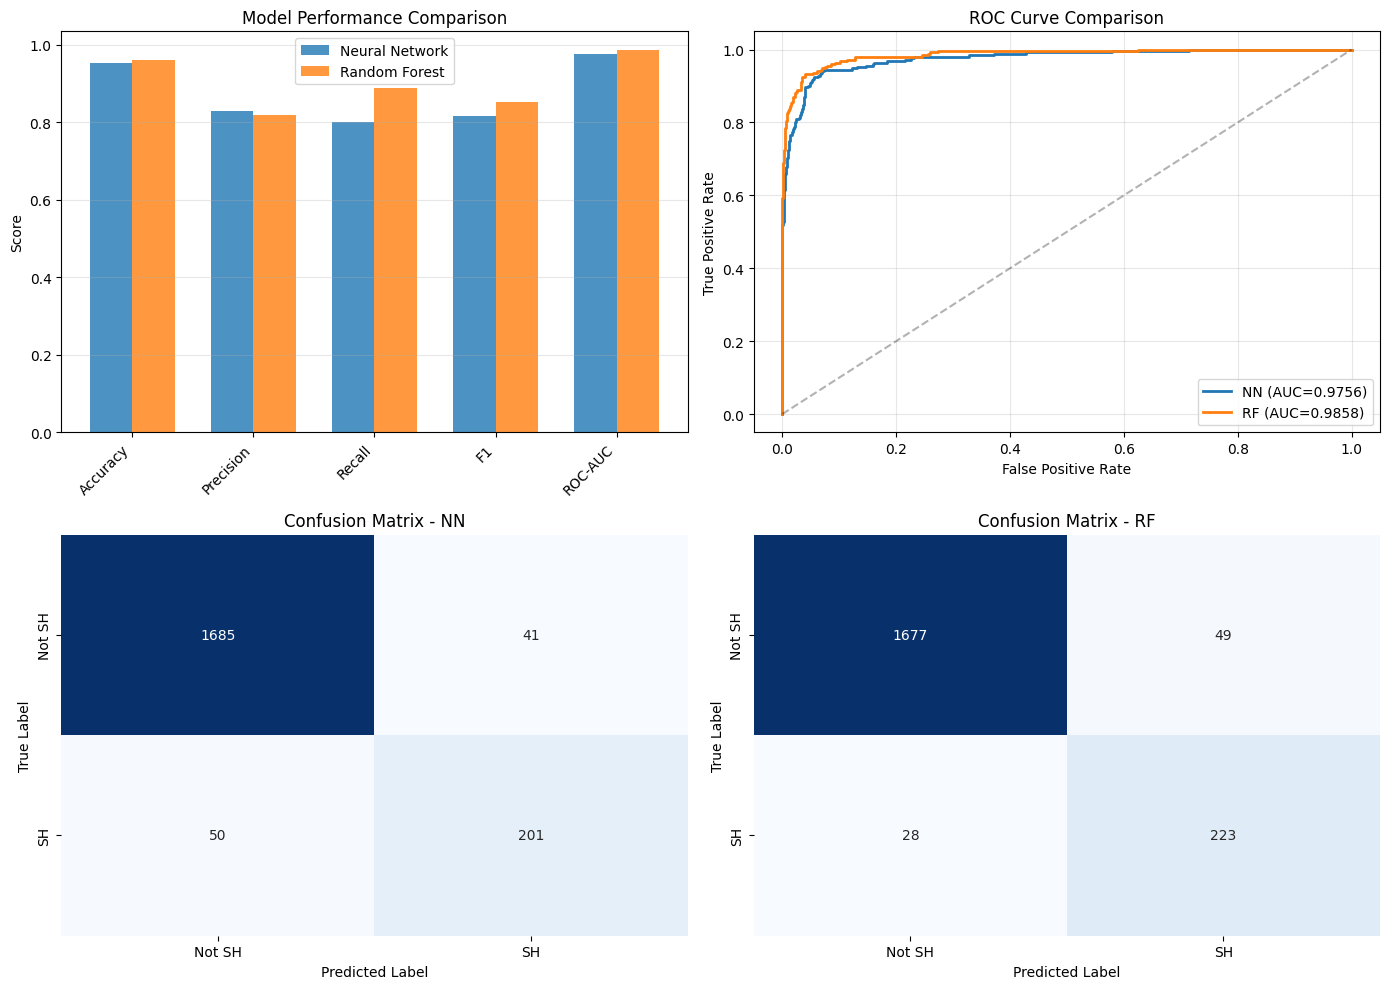

In [227]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Metrics Comparison Bar Chart
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
x = np.arange(len(metrics_to_plot))
width = 0.35

ax = axes[0, 0]
nn_vals = [metrics["val"][m] for m in metrics_to_plot]
rf_vals = [rf_metrics[m] for m in metrics_to_plot]

ax.bar(x - width / 2, nn_vals, width, label="Neural Network", alpha=0.8)
ax.bar(x + width / 2, rf_vals, width, label="Random Forest", alpha=0.8)
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)

fpr_nn, tpr_nn, _ = roc_curve(y_val_np, val_final_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_val_np, rf_val_probs)

ax = axes[0, 1]
ax.plot(fpr_nn, tpr_nn, label=f"NN (AUC={metrics['val']['ROC-AUC']:.4f})", linewidth=2)
ax.plot(fpr_rf, tpr_rf, label=f"RF (AUC={rf_metrics['ROC-AUC']:.4f})", linewidth=2)
ax.plot([0, 1], [0, 1], "k--", alpha=0.3)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve Comparison")
ax.legend()
ax.grid(alpha=0.3)

# 3. Confusion Matrices Side-by-Side
cm_nn = metrics["confusion_matrix"]
cm_rf = confusion_matrix(y_val_np, rf_val_preds)

for idx, (cm, title) in enumerate([(cm_nn, "NN"), (cm_rf, "RF")]):
    ax = axes[1, idx]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax,
        cbar=False,
        xticklabels=["Not SH", "SH"],
        yticklabels=["Not SH", "SH"],
    )
    ax.set_title(f"Confusion Matrix - {title}")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "nn_vs_rf_comparison.png", dpi=300)
plt.show()

## Summary
1. **Model Architecture**
   - Pyramidal structure of 127 → 64 → 32 → 2 neurons, progressively compressing information for binary classification.
   - Each hidden layer included BatchNorm1d for stable training, Dropout (rates of 0.5 and 0.4) to prevent overfitting, and ReLU activation for non-linearity.


2. **Model Performance**
    - Neural Network Model performs identically to the Random Forest Classifier, with a Balanced Accuracy of 88.85% and ROC-AUC of 97.56%.
    - Difference in performance is unlikely to be statistically significant